The chosen naive bayes method for this assignment was the Gaussian Naive Bayes for one reason.
Since we are working with continuous variables this was the best choice since the mathematical formula allows for such variables.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#Read the iris dataset and remove frist row (r,r,r,r,n)
dataset = pd.read_csv("iris.tmls")
dataset = dataset.drop([0, 0])

In [3]:
def getPriorProbability(trainingData):
    strains = trainingData["class"].unique()
    columnNames = trainingData.columns.tolist()
    result = {}

    #Calculates prior probabilities for each strain in the training dataset
    for strain in strains:
        preProb = len(trainingData[trainingData["class"] == strain]) / trainingData.shape[0]
        result[strain] = preProb
    return result

In [4]:
def getPosteriorProbability(dataframe, strain, columnValue, columnName):
    #Remove the nominal class containing flower strains for colculation
    dataframe = dataframe[dataframe["class"] == strain]

    #Get the mean, standard deviation, and variance
    mean = dataframe[columnName].astype(float).mean()
    standardDeviation = dataframe[columnName].astype(float).std()
    variance = np.power(standardDeviation, 2)

    #Gaussian Naive Bayes Formnula (https://iq.opengenus.org/content/images/2020/02/Screenshot_6.jpg)
    return 1/(np.sqrt(2*np.pi*variance))*np.exp(-(np.power(columnValue-mean, 2)/(2*variance)))


In [5]:
def gaussianNaiveBayes(trainingData, testData):
    priorProbabilities = getPriorProbability(trainingData)
    columnNames = testData.columns.tolist()
    columnNames.pop()
    strains = testData["class"].unique()
    predictions = []

    #Work with one row at the time from the test set
    for i in range(len(testData)):
        dataRow = testData.iloc[[i]]
        
        bestScore = -np.inf
        predictedStrain = ""

        #Check the posterior probability for both strains of flower to check which one is the likleliest depending on the gaussian naive bayes score
        for strain in strains:
            score = priorProbabilities.get(strain)
            for columnName in columnNames:
                value = float(dataRow.iloc[-1][columnName])
                score *= getPosteriorProbability(trainingData, strain, value, columnName)
            if(score > bestScore):
                bestScore = score
                predictedStrain = strain
        predictions.append({"strain": predictedStrain, "score": bestScore})
    
    #Return all the predictions alongside its score and also which strains where used this time around
    return predictions, strains                

In [6]:
def dataPreperation(dataframe, testIndex, kVal):
    #Shuffle the dataframe and reset its indexes
    dataframe = dataframe.sample(frac=1)
    dataframe = dataframe.reset_index(drop=True)

    #Split the dataframe into k blocks
    blocks = np.array_split(dataframe, kVal)
    
    testData = blocks[testIndex]
    del blocks[testIndex]
    trainingData = pd.concat(blocks)
    
    return trainingData, testData


In [7]:
def falseAndTruePositives(threshold, predictedStrains, predictedScores, usedStrains):
    positiveVal = usedStrains[0]
    #Count how many times one index is predicted, here we use the first strain as possitive and the other as negative
    positives = 0
    for ps in predictedStrains:
        if ps == positiveVal:
            positives += 1
    negatives = 10 - positives

    tfpr = []

    #Iterate every threshold and count true/false positives
    for th in threshold:
        tp = 0
        fp = 0
        for i in range(len(predictedScores)):
            if(th < predictedScores[i]):
                if(predictedStrains[i] == usedStrains[0]):
                    tp += 1
                else:
                    fp += 1

        #Divide corresponding positives with number of positives and negatives to get true and false positve rates.
        tfpr.append([tp/positives, fp/negatives])

    return tfpr

['Iris-versicolor' 'Iris-virginica']
AUC = 0.534, Acc = 0.96


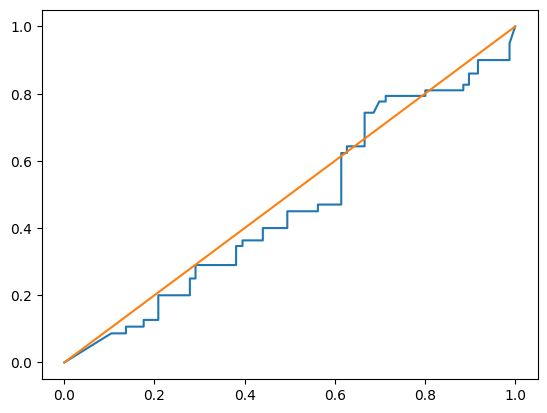

['Iris-virginica' 'Iris-setosa']
AUC = 0.335, Acc = 1.0


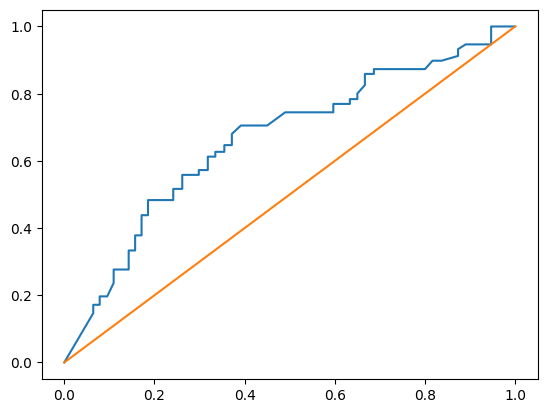

['Iris-versicolor' 'Iris-setosa']
AUC = 0.572, Acc = 1.0


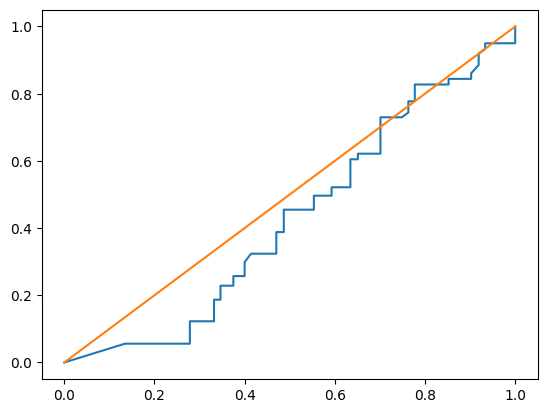

In [8]:
#k-fold value, 10 for this assignment
kVal = 10

classes = dataset["class"].unique()

for cl in classes:
    #Remove one of the strains from this iteration
    dataframe = dataset[dataset["class"] != cl]
    dataframe = dataframe.reset_index(drop=True)

    acc = 0
    rocPoints = [[0.0, 0.0]] * 1000

    for i in range(kVal):
        #Get the training and test data, changes every iteration
        trainingData, testData = dataPreperation(dataframe, i, kVal)

        #Get the predictions(classification and score) alongside which strain were used this iteration
        predictions, usedStrains = gaussianNaiveBayes(trainingData, testData)

        predictionScores = []
        predictionStrains = []

        for prediction in predictions:
            predictionScores.append(prediction.get("score"))
            predictionStrains.append(prediction.get("strain"))

        actualStrains = testData["class"].tolist()

        #Count how many classifications were correct, add to accuracy
        for j in range(len(actualStrains)):
            if actualStrains[j] == predictionStrains[j]:
                acc += 1

        #add thresholds from a point where everything is counted as negative, to a point where everything is counted as a positive
        threshold = np.linspace(-0.1, np.max(predictionScores), 1000)

        #get the true and false positive rates
        tfpr = falseAndTruePositives(threshold, predictionStrains, predictionScores, usedStrains)

        #sum upp all the value pairs from all the splits
        rocPoints = [[sum(pair) for pair in zip(*pairs)] for pairs in zip(rocPoints, tfpr)]

    #get the mean value for each label runned, round up to only two decimals
    rocPoints = [[item / 10 for item in subl] for subl in rocPoints]
    roc_tempDF = (pd.DataFrame(rocPoints, columns = ["tpr","fpr"]))

    print(usedStrains) 

    #calculate AUC
    auc = np.trapz(roc_tempDF.tpr, roc_tempDF.fpr).round(3)

    #Create the ROC curve
    plt.plot(roc_tempDF.tpr, roc_tempDF.fpr)
    plt.plot([0, 1])

    print("AUC = " + str(-auc) + ", Acc = " + str(acc/100))
    plt.show()


        